![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Satellite Land Cover trend assessment for Spatial Planning and Land Management

Production date: 20-12-2024

Produced by: Inês Girão (+ATLANTIC)

## 🌍 Use case: Using land cover products to quantify afforestation/deforestation trends

## ❓ Quality assessment question
* **Is the dataset accurate and consistent for the analysis of afforestation/deforestation trends in the Iberian Peninsula?**


Land Cover data is an invaluable resource for a wide range of fields, from climate change research to forest management. Land Cover products that provide historical timelines enable scientists, policymakers, and planners to understand and analyse the transformation of land cover over recent decades ([EUROSTAT,2022](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Forests,_forestry_and_logging); [New EU Forest Strategy for 2030](https://commission.europa.eu/document/cf3294e1-8358-4c93-8de4-3e1503b95201_en)).

This notebook will access the ***Land cover classification gridded maps from 1992 to present derived from satellite observations*** (henceforth, LC) data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse the spatial patterns of a specific LC type over a given Area of Interest (AoI) and time.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
The dataset maintains strong temporal continuity, with annual updates ensuring a smooth and reliable representation of forest land cover changes over time. While breakpoints were identified, they generally did not indicate major disruptions, reinforcing the dataset’s stability for long-term trend analysis.

The presence of breakpoints does not necessarily indicate abrupt landscape shifts but rather highlights the sensitivity of detection methods to gradual changes. This suggests that while breakpoints can help refine analysis, their impact on overall trends remains limited, emphasising the dataset’s resilience to minor variations.

For the specific land cover type analysed, the dataset exhibits a consistent ability to capture underlying trends. The similarity in results across segmented and total trends suggests that the data structure is well-calibrated, minimising distortions that could arise from classification inconsistencies or methodological biases.

```

![Forest_Map_Series.png](Forest_Map_Series.png)

## 📋 Methodology

**This Use Case comprises the following steps:**

**[](satellite_satellite-land-cover_completeness_q03:code-section-1)**

**[](satellite_satellite-land-cover_completeness_q03:code-section-2)**

**[](satellite_satellite-land-cover_completeness_q03:code-section-3)**

**[](satellite_satellite-land-cover_completeness_q03:code-section-4)**

**[](satellite_satellite-land-cover_completeness_q03:code-section-5)**

## 📈 Analysis and results

(satellite_satellite-land-cover_completeness_q03:code-section-1)=
### **1. Define the AoI, search and download LC data**
Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

#### Install CDS API
To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).
If you already have the CDS API installed, you can skip or comment this step.

In [1]:
!pip install cdsapi

##### Import all the libraries/packages

We will be working with data in NetCDF format. To best handle this type of data we will use libraries for working with multidimensional arrays, in particular Xarray. 
We will also need libraries for plotting and viewing data.

In [2]:
#  Import Standard Libraries
import random
from collections import defaultdict

#  Import Numerical & Statistical Libraries
import numpy as np
import pandas as pd
import xarray as xr
import dask
from scipy.stats import linregress, f, kendalltau, theilslopes
from statsmodels.api import OLS
from numpy.polynomial.polynomial import Polynomial
import ruptures as rpt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

#  Import Geospatial Libraries
import geopandas as gpd  # Import vector geospatial data
import regionmask  # Transform attributes and geometries into specific regions
from shapely.geometry import box, Polygon


#  Import Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm, Normalize
from matplotlib.patches import Patch


#  Import External Tools
from c3s_eqc_automatic_quality_control import download, plot, utils

##### Data Overview

To search for data, visit the CDS website: http://cds.climate.copernicus.eu Here you can search for 'Satellite observations' using the search bar. The data we need for this tutorial is the ***Land cover classification gridded maps from 1992 to present derived from satellite observations***. This catalogue entry provides global Land Cover Classification (LCC) maps with a very high spatial resolution, with a L4 processing level, on an annual basis with a one-year delay, following the [Global Climate Observing System (GCOS) convention requirements](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245). LULC maps correspond to a global classification scheme, encompassing 22 classes.

The dataset consists of 2 versions (v2.0.7 produced by the European Space Agency (ESA) Climate Change Initiative (CCI) and v2.1.1 produced by Copernicus Climate Change Service (C3S)).

Data specifications for this use case:
* **Years:** 1992 to 2022
* **Version:** v2.0.7 before 1992 and v2.1.1 after 2016
* **Format:** Zip files

At the end of the download form, select “**Show API request**”. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook. Having copied the API request, running it will retrieve and download the data you requested into your local directory. However, before you run it, the **terms and conditions** of this particular dataset need to have been accepted directly at the CDS website. The option to view and accept these conditions is given at the end of the download form, just above the “**Show API request**” option. In addition, it is also useful to define the time period and AoI parameters and edit the request accordingly, as exemplified in the cells below.

In [3]:
#Years to download
years = [1992, 1993, 1994,
        1995, 1996, 1997,
        1998, 1999, 2000,
        2001, 2002, 2003,
        2004, 2005, 2006,
        2007, 2008, 2009,
        2010, 2011, 2012,
        2013, 2014, 2015,
        2016, 2017, 2018,
        2019, 2020, 2021,
        2022, 2022]


# List of requests to retrieve data
collection_id = "satellite-land-cover"
requests = [
    {
        "variable": "all",
        "format": "zip",
        "version": "v2_0_7cds" if year < 2016 else "v2_1_1",
        "year": str(year),
        "area": [45, -10, 35, 4] # Region of interest (Iberian Peninsula)
    }
    for year in years
]

In [4]:
# Download the dataset
ds = download.download_and_transform(
    collection_id,
    requests,
    n_jobs=2
)
ds = ds.assign_coords(year=ds["time"].dt.year).swap_dims(time="year").drop("time")

100%|██████████| 32/32 [00:00<00:00, 122.07it/s]
/tmp/ipykernel_867327/1703755849.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.assign_coords(year=ds["time"].dt.year).swap_dims(time="year").drop("time")


In [5]:
#Inspect the database
ds

<xarray.Dataset> Size: 7GB
Dimensions:              (year: 31, latitude: 3600, longitude: 5040, bounds: 2)
Coordinates:
    lat_bounds           (latitude, bounds) float64 58kB dask.array<chunksize=(3600, 2), meta=np.ndarray>
    lon_bounds           (longitude, bounds) float64 81kB dask.array<chunksize=(5040, 2), meta=np.ndarray>
    time_bounds          (year, bounds) datetime64[ns] 496B dask.array<chunksize=(1, 2), meta=np.ndarray>
  * latitude             (latitude) float64 29kB 45.0 45.0 44.99 ... 35.0 35.0
  * longitude            (longitude) float64 40kB -9.999 -9.996 ... 3.996 3.999
  * year                 (year) int64 248B 1992 1993 1994 ... 2020 2021 2022
Dimensions without coordinates: bounds
Data variables:
    lccs_class           (year, latitude, longitude) uint8 562MB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    processed_flag       (year, latitude, longitude) float32 2GB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    current_pixel_state  (year, latitude, longitude) float32 2GB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    observation_count    (year, latitude, longitude) uint16 1GB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    change_count         (year, latitude, longitude) uint8 562MB dask.array<chunksize=(1, 1800, 2520), meta=np.ndarray>
    crs                  (year) int32 124B -2147483647 ... -2147483647
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

(satellite_satellite-land-cover_completeness_q03:code-section-2)=
### **2. Inspect and view data for the defined AoI (Iberian Peninsula)**
#### Compute Land Cover classes area coverage for each NUTS 2 region

To identify changes in LC patterns, by regions, NUTS 2 will be used, providing the information regarding the main regions of Iberian Peninsula.

The NUTS are a hierarchical system divided into 3 levels (https://ec.europa.eu/eurostat/web/nuts). NUTS 1 correspond to major socio-economic regions, NUTS 2 correspond to basic regions for the application of regional policies, and NUTS 3 correspond to small regions for specific diagnoses. Additionally a NUTS 0 level, usually co-incident with national boundaries is also available. The NUTS legislation is periodically amended; therefore multiple years are available for download. 

#### Mask regions

First, we need to establish the geometry of the NUTS region (level 2) in order to make the corresponding statistics.

In [6]:
# Configure Dask
dask.config.set(scheduler='threads', **{'array.slicing.split_large_chunks': True})

# Define CRS and bounding box for Iberian Peninsula
crs_wgs84 = "EPSG:4326"
iberian_bbox = box(-10, 36, 3.5, 44)

# Load and filter GeoDataFrame
shapefile_url = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/shp/NUTS_RG_20M_2021_4326.shp.zip"
gdf = gpd.read_file(shapefile_url)
gdf = gdf[gdf["LEVL_CODE"] == 2]
gdf = gdf[gdf["NUTS_ID"].str.startswith(("ES", "PT"))]  # Spain (ES) and Portugal (PT)
gdf = gdf.to_crs(crs_wgs84)
gdf = gdf[gdf.intersects(iberian_bbox)]
gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty]

if gdf.empty:
    raise ValueError("No valid geometries found after filtering.")

# Ensure dataset CRS is set
if ds.rio.crs is None:
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)

# Ensure dataset coordinates overlap with the filtered regions
filtered_lon_min, filtered_lat_min, filtered_lon_max, filtered_lat_max = gdf.total_bounds
if (
    ds["longitude"].min().values > filtered_lon_max
    or ds["longitude"].max().values < filtered_lon_min
    or ds["latitude"].min().values > filtered_lat_max
    or ds["latitude"].max().values < filtered_lat_min
):
    raise ValueError(
        "Dataset coordinates do not overlap with the filtered regions. Check dataset and region alignment."
    )

# Subset dataset to valid ranges
ds = ds.sel(
    longitude=slice(
        max(filtered_lon_min, ds["longitude"].min().values),
        min(filtered_lon_max, ds["longitude"].max().values)
    ),
    latitude=slice(
        min(filtered_lat_max, ds["latitude"].max().values),
        max(filtered_lat_min, ds["latitude"].min().values)
    )
)

# Check subset dataset dimensions
if ds["longitude"].size == 0 or ds["latitude"].size == 0:
    raise ValueError("Subset resulted in an empty dataset. Check the bounds and ensure overlap.")

# Create the regionmask
regions = regionmask.from_geopandas(gdf, names="NUTS_NAME")

# Create a 2D mask
mask = regions.mask(ds["longitude"], ds["latitude"])

ds= ds.where(mask.notnull(), drop=True)

#### Compute cell area

Then, we can calculate the area of each pixel taking into consideration the curvature of the earth (i.e., weighted by the cosine of Latitude).

In [7]:
# Scaling factor for conversion (constant longitude resolution)
scaling_factor = 0.002778  # Degrees
resolution_lon_km = scaling_factor * 111.195  # Longitude resolution in kilometres

# Use the latitude values directly from the dataset
lats = ds["latitude"]

# Calculate the difference between consecutive latitude values
lat_diff = np.abs(np.diff(lats.values))  # Absolute differences
lat_diff = np.append(lat_diff, lat_diff[-1])  # Assume the last cell has the same size as the one before

# Convert latitude differences to kilometres
resolution_lat_km = lat_diff * 111.195  # Latitude-dependent resolution

# Compute the grid cell area for each latitude
grid_cell_area = resolution_lon_km * resolution_lat_km * np.cos(np.radians(lats))

# Assign attributes to the grid cell area
grid_cell_area.attrs = {
    "standard_name": "cell_area",
    "long_name": "Grid cell area",
    "units": "km²",
}

# Add the grid cell area as a coordinate to the dataset
ds = ds.assign_coords(cell_area=("latitude", grid_cell_area.data))  # Use `.data` to extract the array


#### Select Forest Classes and Prepare Dataset

In [8]:
# Define forest classes
forest_classes = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170]

# Create a mask for forested areas
forest_mask = ds['lccs_class'].isin(forest_classes)

# Masked forest area using cell area
ds_forest_area = ds['cell_area'].where(forest_mask)

# Stack latitude and longitude into a single dimension
ds_forest_area = ds_forest_area.stack(stacked_lat_lon=("latitude", "longitude"))

# Create a stacked mask and align dimensions
stacked_mask = mask.stack(stacked_lat_lon=("latitude", "longitude"))
stacked_mask.name = "stacked_mask"

# Attach the stacked mask to the dataset
ds_forest_area = ds_forest_area.assign_coords(stacked_mask=stacked_mask)

# Group by regions and compute forested area for each year
forest_area_by_region = (
    ds_forest_area.groupby("stacked_mask")
    .sum(dim="stacked_lat_lon")
    .compute()
)

#### Compute forest area per region and year

In [9]:
results = []
growth = {}

for reg, reg_area in forest_area_by_region.groupby("stacked_mask"):
    if np.isnan(reg):  # Skip NaN regions
        continue

    # Ensure valid region indexing and naming
    region_name = regions[int(reg)].name
    years = ds_forest_area['year'].values
    values = reg_area.values.flatten()  # Flatten in case of higher-dimensional arrays

    # Save growth data by year
    if len(values) > 0:
        growth[region_name] = {int(year): float(value) for year, value in zip(years, values)}
    else:
        growth[region_name] = {}  # Handle regions with no data

    # Add results to the list
    for year, value in zip(years, values):
        results.append({
            "Region": region_name,
            "Year": int(year),
            "Forest_Area": float(value)
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Add geometry to results_df
if 'NUTS_NAME' in gdf.columns:
    results_df = pd.merge(results_df, gdf[['NUTS_NAME', 'geometry']], left_on="Region", right_on="NUTS_NAME", how="left")
else:
    print("Warning: NUTS_NAME column not found in gdf.")

# Ensure results_df is a GeoDataFrame
if not isinstance(results_df, gpd.GeoDataFrame):
    results_df = gpd.GeoDataFrame(results_df, geometry=gpd.GeoSeries(results_df['geometry']), crs="EPSG:4326")

#### Map forest percentage coverage over-time by NUTS regions in the AoI

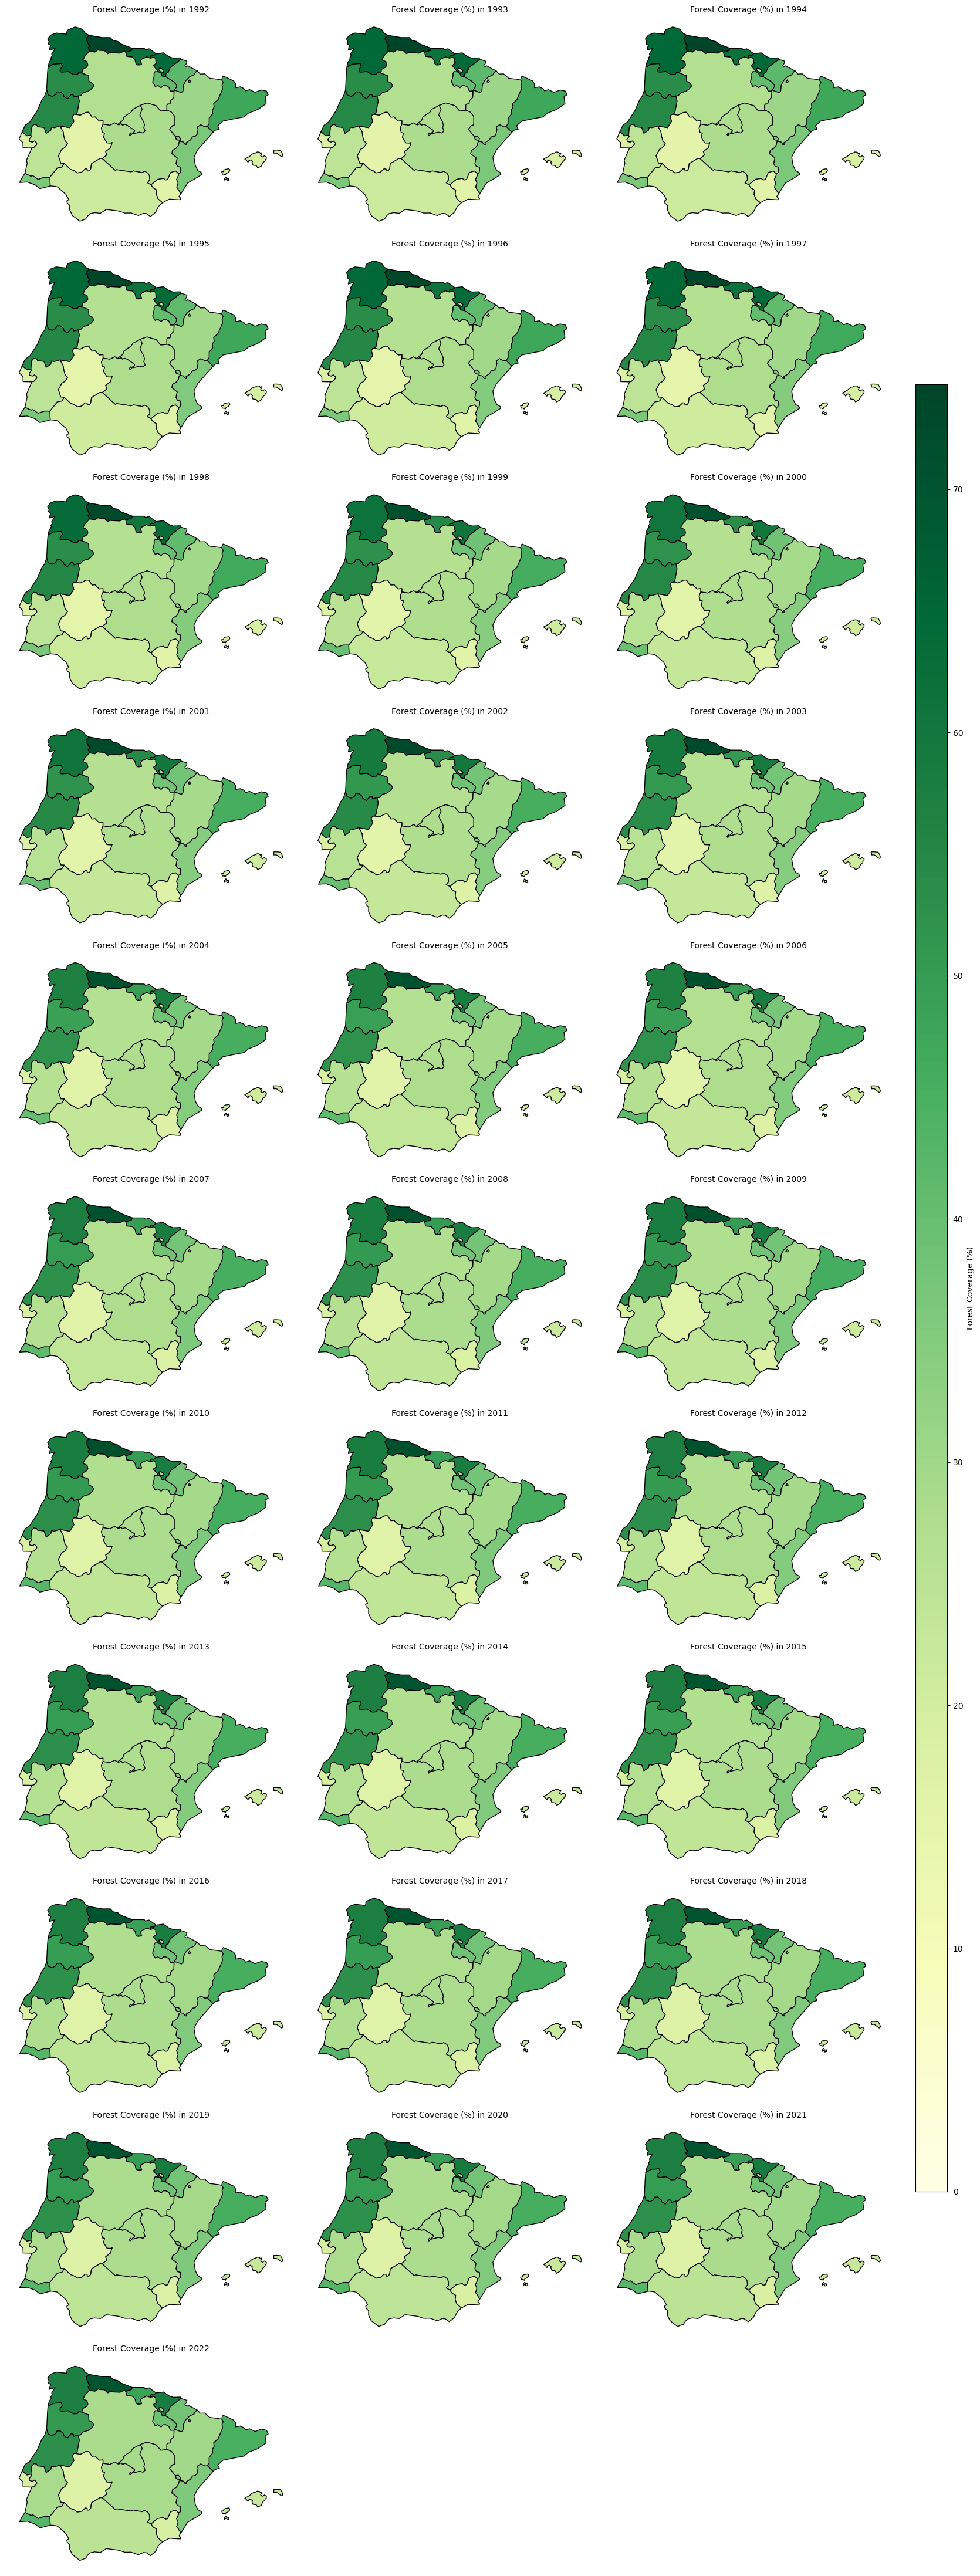

In [10]:
# Reproject the GeoDataFrame to a projected CRS (EPSG:3035 is a good choice for Europe)
results_df = results_df.to_crs("EPSG:3035")

# Calculate the total area of each region (in square kilometers)
results_df["Region_Total_Area"] = results_df.geometry.area / 10**6  # Convert from m² to km²

# Ensure 'Year' is converted to string if needed
results_df['Year'] = results_df['Year'].astype(str)

#Calculate Forest Percentage
results_df['Forest_Percentage'] = (results_df['Forest_Area'] / results_df['Region_Total_Area']) * 100

# Pivot the data to have years as columns
forest_pivot = results_df.pivot(index='Region', columns='Year', values='Forest_Percentage').reset_index()

# Extract years for plotting
years = [col for col in forest_pivot.columns if col.isdigit()]

# Normalize color scale across all maps based on percentage coverage
norm_percentage = Normalize(vmin=0, vmax=results_df['Forest_Percentage'].max())

# Plot settings
n_cols = 3
n_rows = int(np.ceil(len(years) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), squeeze=False)

# Plot each year in a separate subplot
for idx, year in enumerate(years):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    results_df_year = results_df[results_df['Year'] == year]
    results_df_year.plot(column='Forest_Percentage', cmap="YlGn", ax=ax, edgecolor="k", norm=norm_percentage)
    ax.set_title(f"Forest Coverage (%) in {year}", fontsize=10)
    ax.axis('off')

# Hide unused subplots
for idx in range(len(years), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].axis('off')

# Step 8: Adjust layout
plt.tight_layout()

# Allocate space for the color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Create a new axes for color bar

# Create a single ScalarMappable object for the common colorbar
sm_common = plt.cm.ScalarMappable(cmap="YlGn", norm=norm_percentage)
sm_common._A = []  # Dummy array for the scalar mappable
fig.colorbar(sm_common, cax=cbar_ax, label="Forest Coverage (%)")

plt.show()

#### Map forest percentage coverage change over-time by NUTS regions in the AoI

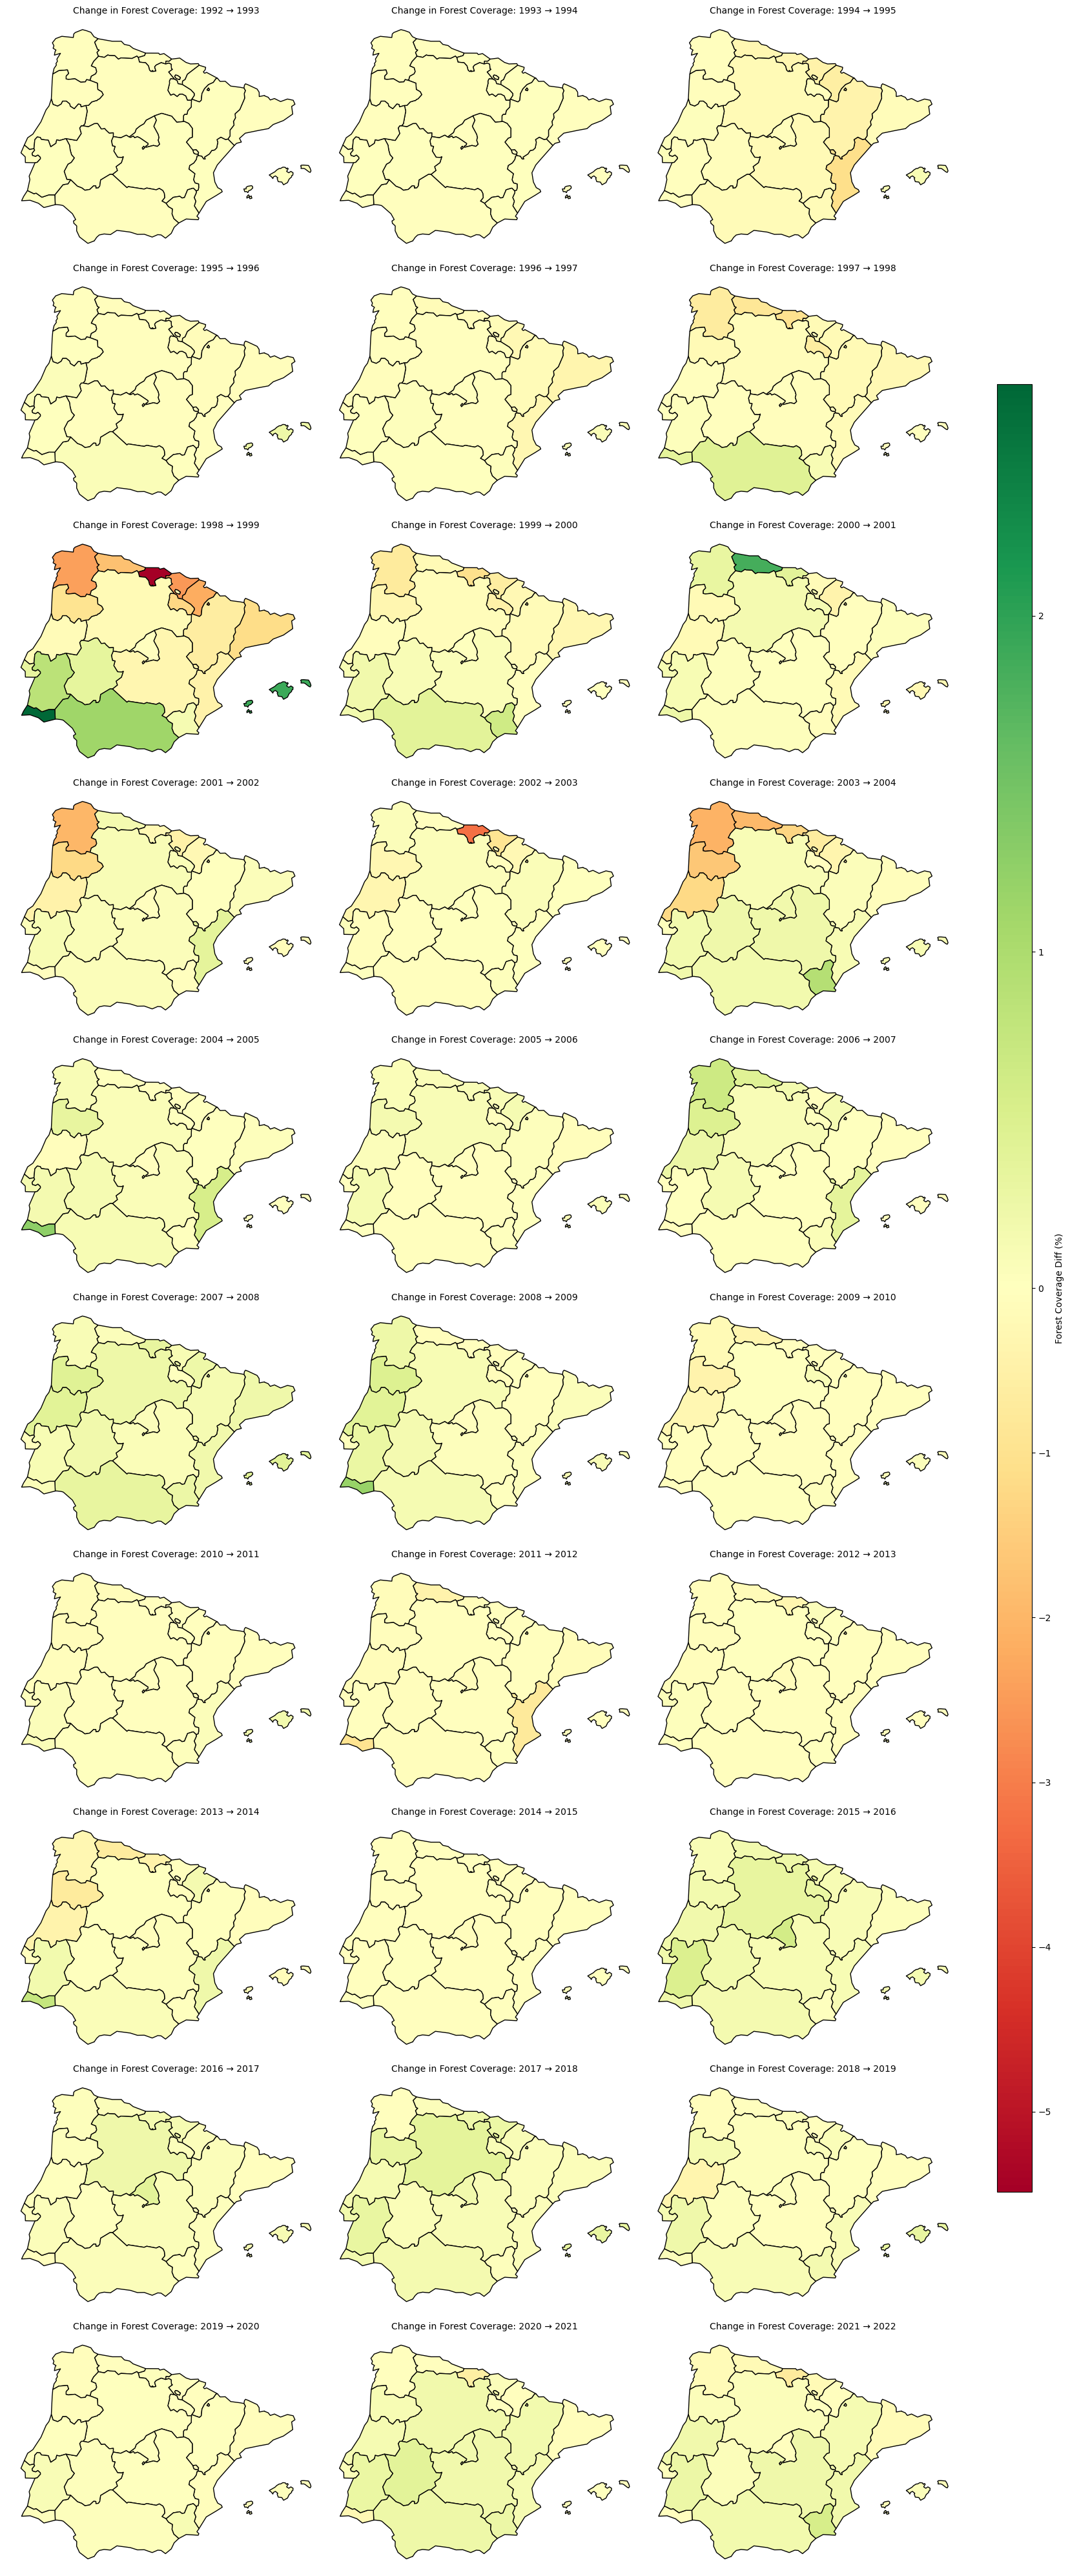

In [11]:
# Calculate the year-over-year percentage differences for each region
results_df['Forest_Percentage_Diff'] = results_df.groupby('Region')['Forest_Percentage'].diff()

# Automatically exclude the first year
first_year = int(results_df['Year'].min())  # Ensure the first year is an integer
filtered_years = sorted(results_df['Year'].astype(int).unique())  # Ensure years are integers
filtered_years = [year for year in filtered_years if year != first_year]  # Exclude the first year

# Normalize color scale around zero (e.g., -6 to +6 with 0 as neutral)
norm_diff = TwoSlopeNorm(vmin=results_df['Forest_Percentage_Diff'].min(), vcenter=0, vmax=results_df['Forest_Percentage_Diff'].max())

# Plot settings
n_cols = 3
n_rows = int(np.ceil(len(filtered_years) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4), squeeze=False)

# Improved color scale: Diverging with neutral at zero
cmap = "RdYlGn"

# Plot each year in a separate subplot
for idx, year in enumerate(filtered_years):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    results_df_year = results_df[results_df['Year'].astype(int) == year]
    previous_year = year - 1  # Ensure year is treated as an integer
    results_df_year.plot(column='Forest_Percentage_Diff', cmap=cmap, ax=ax, edgecolor="k", norm=norm_diff)
    ax.set_title(f"Change in Forest Coverage: {previous_year} → {year}", fontsize=10)
    ax.axis('off')

# Hide unused subplots
for idx in range(len(filtered_years), n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].axis('off')

# Adjust layout
plt.tight_layout()

# Allocate space for the color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Create a new axes for the color bar

# Create a single ScalarMappable object for the common colorbar
sm_common = plt.cm.ScalarMappable(cmap=cmap, norm=norm_diff)
sm_common._A = []  # Dummy array for the scalar mappable
fig.colorbar(sm_common, cax=cbar_ax, label="Forest Coverage Diff (%)")

plt.show()

#### Map Analysis

- Over the 28-year period, all regions maintain a consistent area of forest.

- Regions such as Principado de Asturias, Cantabria, País Vasco, Galicia, and Centro (PT) consistently exhibit the highest levels of forest coverage.

- Northern Spain (Galicia, Asturias, Cantabria, País Vasco) is often affected by negative fluctuations, particularly in 1998–2000 and 2003–2004. The classification models may have struggled with complex topography and mixed vegetation types [(Zhao et al., 2023)](https://www.mdpi.com/2072-4292/15/9/2285). 

- Southern Portugal & Spain (Alentejo, Algarve, Andalucía), unlike northern Spain, experiences more positive fluctuations in area, particularly in 1998-2004.

- From 2006–2007 onward the maps show more stable estimates.

#### **Potential Drivers and Methodological Considerations in Afforestation/Deforestation Trends in the Iberian Peninsula (1992–2022)**

Forest dynamics in the Iberian Peninsula over the last three decades have been shaped by a combination of **natural events**, **human activities**, and **policy interventions**. Before analysing trends in a land use and land cover (LULC) time series, it is crucial to account for abrupt shifts that may distort trend estimates. These shifts, often referred to as breakpoints, can result from:

**Natural Events**

- Wildfires:  The Iberian Peninsula experiences frequent and intense wildfires, particularly in **Galicia, Catalonia, and central Portugal**. Major fire seasons occurred in **2003, 2005, and 2017**, causing the destruction of vast areas of forest [(Mato et al., 2014)](https://api.semanticscholar.org/CorpusID:265869582). Wildfires have become a key driver of land cover change, especially in fire-prone regions of Portugal and Spain [(Silva et al., 2011)](https://doi.org/10.1016/j.landurbplan.2011.03.001).  

- **Droughts:**  Recurrent droughts have exacerbated forest degradation, weakening tree resilience and delaying post-fire recovery [(Gouveia et al., 2012)](https://nhess.copernicus.org/articles/12/3123/2012/). The severe droughts of **2005 and 2017** significantly reduced vegetation cover, affecting Mediterranean pine and oak forests [(Vidal-Macua et al., 2017)](https://doi.org/10.1016/j.foreco.2017.10.011).  

**Human Activities** 

- Farmland Abandonment: Rural depopulation since the 1990s has driven widespread farmland abandonment, leading to natural forest regeneration in regions like **northern Portugal and Galicia** [(Palmero-Iniesta et al., 2021)](https://api.semanticscholar.org/CorpusID:238829360).  

- Logging and Eucalyptus Plantations:  Logging activities and the expansion of eucalyptus plantations in **Galicia and central Portugal** have caused periodic forest loss and regrowth [(Silva et al., 2011)](https://doi.org/10.1016/j.landurbplan.2011.03.001).  

**Policy and Economic Influences**

- Afforestation and Reforestation: EU-funded afforestation programs under the **Common Agricultural Policy (CAP)** promoted the planting of trees on abandoned farmland, particularly in **Castilla y León, Extremadura, and parts of Portugal**, leading to abrupt increases in forest cover [(Sevillano et al., 2018)](https://doi.org/10.1016/j.landusepol.2018.06.054). 

- Natura 2000 Network and Conservation Policies: The **Natura 2000 network** has contributed to forest conservation efforts, particularly in regions like **Sierra de Guadarrama (Madrid)** and **Peneda-Gerês National Park (Portugal)** [(Regos et al., 2015)](https://doi.org/10.1016/j.jag.2014.11.010).  

- Economic Downturn (2008–2013):  The economic crisis reduced logging temporarily alleviating deforestation pressures (Mateus & Fernandes, 2014).  

**Methodology**  
- Certain shifts in forest cover may be related to data collection and processing rather than actual forest dynamics. For example, transitions between different satellite sensors—**AVHRR (1992–1999), SPOT-VGT (1999–2013), and Sentinel-3 OLCI (2020–2022)**—can introduce artificial breaks in the time series [(Toté et al., 2015)](https://doi.org/10.3390/rs16203822).

| Global SR Composite Time Series | Reference Period | Satellite Data Source | Technical Specifications |
|---------------------------------|------------------|-----------------------|--------------------------|
| AVHRR global SR composite time series | 1992-1999 | AVHRR-2 on NOAA-11 and NOAA-14 | 1 km spatial resolution, 5 spectral bands in visible and infrared, Global coverage |
| SPOT-VGT global SR composites | 1999-2013 | SPOT 4, 5 Vegetation sensor | 1 km spatial resolution, 4 spectral bands in visible, near-infrared (NIR), and shortwave infrared (SWIR), Global coverage |
| MERIS global SR composite time series | 2003-2012 | Envisat MERIS FR & RR | 300 m or 1,000 m resolution full swath, 15 spectral bands in visible and NIR, Global coverage |
| PROBA-V global SR composite time series | 2013-2019 | PROBA-V | 300 m spatial resolution, 4 spectral bands in visible, near-infrared, and SWIR, Global coverage |
| Sentinel-3 OLCI global SR composite time series | 2020 | S3 OLCI | 300 m resolution full swath, 15 spectral bands in visible and NIR, Global coverage |
| Sentinel-3 global SR composite time series | 2021-2022 | S3 OLCI & S3 SLSTR | 300 m resolution full swath, 21 spectral bands in visible, NIR, and SWIR, Global coverage |
| Advanced Synthetic Aperture Radar - Wide Swath Mode (ASAR WSM) time series | 2005-2012 | Envisat ASAR WSM | 150 m spatial resolution, Microwave band, Global coverage |

Ignoring such breakpoints can lead to inaccurate conclusions—either by introducing artificial trends or obscuring real changes.

(satellite_satellite-land-cover_completeness_q03:code-section-3)=
### **3. Breakpoint Detection**

A good first step in assessing potential  impacts on land cover (LC) trends is to apply simple exploratory methods, such as analysing the rate of change (time series derivative). This will help identify sudden shifts in the data.

However, while these approaches highlight points of interest, they do not confirm whether the observed changes are truly structural. Percentage differences can be sensitive to random fluctuations, and derivative-based analyses may exaggerate year-to-year variations that do not necessarily indicate a breakpoint. To formally assess structural changes we apply a statistical breakpoint detection method.


 **Rate of Change Calculation**
- The **first derivative** of the forest area time series is computed to identify **years with significant year-to-year changes**.
- This highlights **periods where the rate of change deviates substantially** from surrounding years, signaling potential anomalies.

 **Statistical Thresholding of Derivative Spikes**
- A threshold is **calculated dynamically** as the **mean absolute derivative plus 1.5 times the standard deviation (1.5σ)**.
- Years where the **absolute rate of change** exceeds this threshold are **flagged as potential breakpoint candidates**.
- This **reduces false positives** by filtering out **minor fluctuations** and focusing on **significant deviations**.

 **Breakpoint Detection Using PELT Algorithm**
- The **Pruned Exact Linear Time (PELT)** algorithm is applied to **detect structural changes** in the dataset.
- The algorithm is run using the **L2 cost function** (`model="l2"`) to minimize segmentation errors.
- The **penalty parameter (`pen`) is dynamically set** as `np.std(forest_area) * 2.5` to balance **false positives and meaningful breakpoints**.
- A **minimum segment length (`min_size=2`)** is used to prevent excessive segmentation.

 **Filtering Breakpoints Based on Derivative Spikes**
- **Only breakpoints that align closely (within ±2 years) with derivative spikes are retained.**
- This **ensures detected breakpoints correspond to actual shifts** rather than **random segmentation artifacts**.
- The breakpoints are then **stored for further regional clustering analysis**.

 **Application of Savitzky-Golay Filtering for Smoothing**
- To **better visualize trends**, the first derivative is **smoothed** using a **Savitzky-Golay filter** with `window_length=5` and `polyorder=2`.
- This helps **reduce noise while preserving significant trend changes**.


### Breakpoint Clusters Across Regions ###
Year 1996.0: 16 regions detected a breakpoint
Year 2001.0: 6 regions detected a breakpoint
Year 2016.0: 4 regions detected a breakpoint


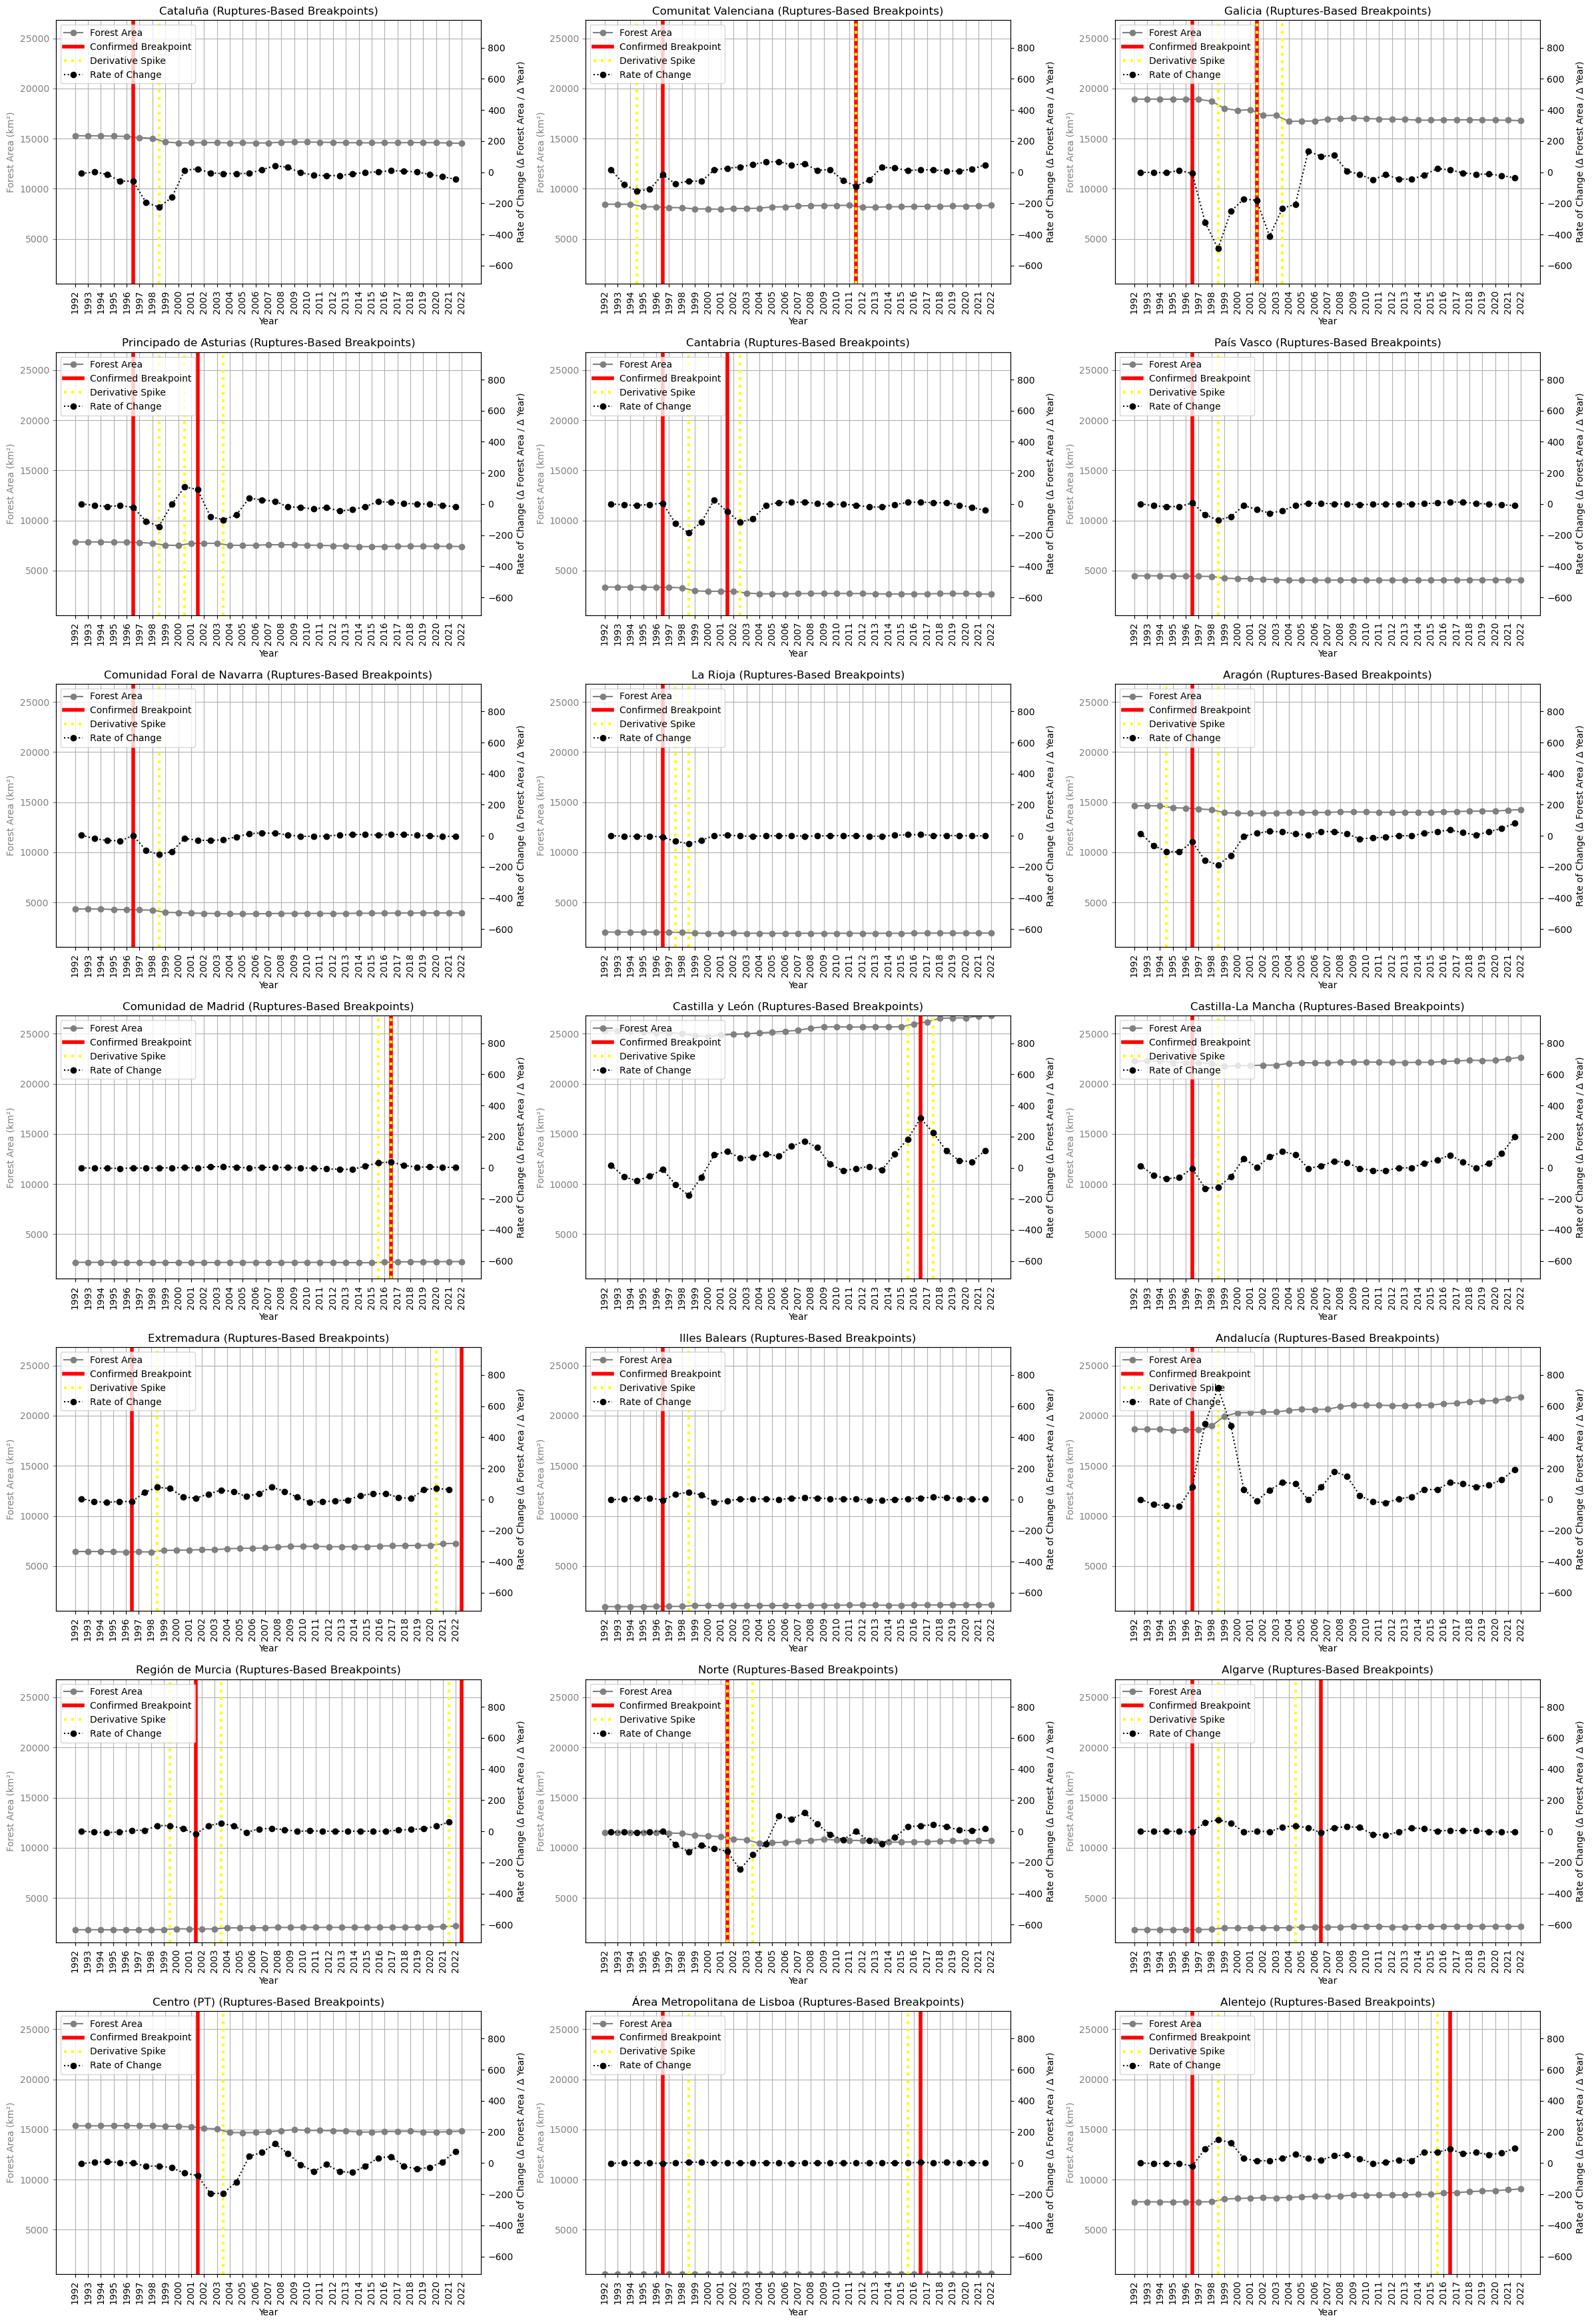

In [12]:
# **Store breakpoints across all regions for clustering analysis**
breakpoint_counts = defaultdict(int)
breakpoint_storage = []  # List to store breakpoints

# **Unique regions from dataset**
unique_regions = results_df["Region"].unique()
n_regions = len(unique_regions)

# **Determine global y-axis limits for Forest Area**
global_y_min = results_df["Forest_Area"].min()
global_y_max = results_df["Forest_Area"].max()

# **Determine global y-axis limits for Rate of Change**
global_derivative_min = float('inf')
global_derivative_max = float('-inf')

# **First Pass: Calculate global min/max for first derivative**
for region in unique_regions:
    region_data = results_df[results_df["Region"] == region]
    years = region_data["Year"].values.astype(float)
    Forest_area = region_data["Forest_Area"].values

    if len(years) > 1:  # Ensure there are at least two years for differentiation
        delta_years = np.diff(years)
        delta_Forest_area = np.diff(Forest_area)
        first_derivative = delta_Forest_area / delta_years  

        global_derivative_min = min(global_derivative_min, np.min(first_derivative))
        global_derivative_max = max(global_derivative_max, np.max(first_derivative))

# **Dynamically set up subplot grid**
n_cols = 3  # Fixed columns for better visualization
n_rows = int(np.ceil(n_regions / n_cols))  # Dynamically determine rows
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 5), squeeze=False)

axes = axes.flatten()  # Flatten to access easily

for idx, region in enumerate(unique_regions):
    ax = axes[idx]
    region_data = results_df[results_df["Region"] == region]
    years = region_data["Year"].values.astype(float)
    Forest_area = region_data["Forest_Area"].values

    # **Calculate the first derivative (rate of change)**
    if len(years) > 1:
        delta_years = np.diff(years)
        delta_Forest_area = np.diff(Forest_area)
        first_derivative = delta_Forest_area / delta_years  
        derivative_years = (years[:-1] + years[1:]) / 2  
    else:
        first_derivative = np.array([])
        derivative_years = np.array([])

    # **Detect potential anomaly years from derivative spikes (Threshold: 1.5σ)**
    if len(first_derivative) > 0:
        derivative_threshold = np.mean(np.abs(first_derivative)) + 1.5 * np.std(first_derivative)
        spike_indices = np.where(np.abs(first_derivative) > derivative_threshold)[0]
        spike_years = years[spike_indices]  
    else:
        spike_years = []

    # **Apply PELT for breakpoint detection**
    algo = rpt.Pelt(model="l2", min_size=2).fit(Forest_area.reshape(-1, 1))
    pen_value = np.std(Forest_area) * 2.5
    detected_breakpoints = np.array(algo.predict(pen=pen_value)) - 1  

    # **Filter breakpoints to keep only those close to derivative spikes**
    confirmed_breakpoints = []
    for bp in detected_breakpoints:
        if any(abs(bp - s) <= 2 for s in spike_indices):
            confirmed_breakpoints.append(bp)
            breakpoint_counts[years[bp]] += 1  
            breakpoint_storage.append({"Region": region, "Year": int(years[bp])})

    # **Apply Savitzky-Golay filter for smoothing**
    if len(first_derivative) >= 5:  
        first_derivative_smoothed = savgol_filter(first_derivative, window_length=5, polyorder=2)
    else:
        first_derivative_smoothed = first_derivative  

    # **Plot Forest area in grey**
    line1, = ax.plot(years, Forest_area, marker='o', color='grey', label="Forest Area")
    ax.set_ylabel("Forest Area (km²)", color="grey")  
    ax.tick_params(axis='y', colors='grey')  
    ax.set_ylim(global_y_min, global_y_max)

    # **Overlay Detected Breakpoints in Red**
    lines_bp = []
    for i, bp in enumerate(confirmed_breakpoints):
        line = ax.axvline(years[bp] + 0.5, color='red', linestyle='-', linewidth=4, label='Confirmed Breakpoint' if i == 0 else None)
        lines_bp.append(line)

    # **Mark Derivative-Based Potential Change Years in Yellow**
    lines_spike = []
    for i, dy in enumerate(spike_years):
        line = ax.axvline(dy + 0.5, color='yellow', linestyle=':', linewidth=3, label='Derivative Spike' if i == 0 else None)
        lines_spike.append(line)

    # **Create a secondary y-axis for the first derivative**
    ax2 = ax.twinx()
    line2, = ax2.plot(derivative_years, first_derivative_smoothed, marker='o', color='black', linestyle='dotted', label="Rate of Change")
    ax2.set_ylabel("Rate of Change (Δ Forest Area / Δ Year)", color='black')  
    ax2.tick_params(axis='y', colors='black')  
    ax2.set_ylim(global_derivative_min, global_derivative_max)

    # **Customize subplot**
    ax.set_xticks(years)
    ax.set_xticklabels(years.astype(int), rotation=90)
    ax.set_title(f"{region} (Ruptures-Based Breakpoints)")
    ax.set_xlabel("Year")
    ax.grid()

    # **Combine legend entries from both y-axes**
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# **Analyze Breakpoint Clusters Across Regions**
print("\n### Breakpoint Clusters Across Regions ###")
for year, count in sorted(breakpoint_counts.items()):
    if count > 2:  
        print(f"Year {year}: {count} regions detected a breakpoint")

# **Hide any unused subplot axes**
for idx in range(n_regions, len(axes)):
    fig.delaxes(axes[idx])

# **Adjust layout and display**
plt.tight_layout()
plt.show()

#### Breakpoint Analysis  

**🛑 Breakpoint [1996]**

-  The 1996 breakpoint coincides with a period of methodological changes in preparation for the launch of SPOT-VGT (1998). These adjustments likely involved recalibrations in land cover classification, improved spectral band processing, and harmonization efforts across datasets. These refinements could have led to systematic shifts in detected forest areas, affecting reported trends in multiple regions.

- Breakpoints were detected in 16 different regions, covering diverse landscapes across the Iberian Peninsula (Mediterranean, Atlantic, and continental climates). This broad spatial distribution suggests a system-wide change in classification methodologies rather than localised environmental drivers. Unlike breakpoints tied to specific ecological or anthropogenic events, a simultaneous shift across diverse regions strongly indicates a methodological cause.

- While forest recovery due to land abandonment and early afforestation programs may have been ongoing, there is no single large-scale event (e.g., policy shifts, extreme wildfires) that would explain a consistent breakpoint across multiple regions. If a real environmental event caused this breakpoint, we would expect regional variability rather than near-universal detection across Iberia.

*Interpretation*

- Primarily methodological → The 1996 breakpoint is most likely due to preparatory changes in land cover classification before SPOT-VGT, leading to apparent shifts in forest cover trends.
- Minor real impacts → Some land abandonment and afforestation efforts may have contributed to real forest cover changes, but they do not explain the widespread breakpoint.

---

**🛑 Breakpoint [2001]**

- The shift from AVHRR (Advanced Very High-Resolution Radiometer) to SPOT-VGT (Vegetation Monitoring Satellite) in 1999 resulted in:
   - Higher spectral resolution, improving vegetation classification.
   - Changes in classification thresholds, possibly altering the way forests were distinguished from shrublands or degraded areas.  

If the new algorithm refined how forests were mapped, it may have caused some areas to show an increase (where vegetation was now classified as forest) and others to show a decrease (where previously overestimated forests were corrected).

- The Iberian Peninsula features diverse landscapes—from Mediterranean shrublands to Atlantic forests—which may have responded differently to classification changes:
  - Densely forested regions (e.g., Galicia, Asturias) may have been more stable or even increased.
  - Semi-arid or mixed-use landscapes (e.g., Andalusia, Valencia) may have seen a decrease as improved classification separated forests from scrublands or agricultural areas.

Regional variability in land cover complexity could have amplified the mixed effects of the breakpoint.

- In 1990s-early 2000s the EU reforestation programs were expanding, but simultaneously, urban expansion and logging persisted. While afforestation policies may have caused increases in some areas, land-use change, fires, and agricultural expansion may have driven declines elsewhere. However, given that three regions increased and three decreased, this explanation alone is insufficient—a sensor-driven change remains the more likely factor.

*Interpretation*

Mostly methodological → The SPOT-VGT transition likely led to regionally dependent classification adjustments, explaining the inconsistent increases and decreases.  
Some real effects → Local deforestation and afforestation trends may have reinforced or counteracted the methodological shift, but they are not the primary driver of the breakpoint.  

Unlike 1996, which was a widespread methodological breakpoint, 2001 shows mixed behaviour across regions. This suggests a recalibration in classification methods rather than a universal environmental event.
Sensor shifts do not always affect all regions in the same way—differences in land cover complexity likely influenced how SPOT-VGT changes were perceived across the Iberian Peninsula.

---

**🛑 Breakpoint [2016]**

- The transition to Sentinel-2 imagery with 10m spatial resolution significantly improved land cover classification, particularly in detecting small or fragmented forest patches. Enhanced classification algorithms further increased the ability to distinguish between forests, shrublands, and other vegetated areas, leading to adjustments in areas previously considered stable These changes affected both urban-periurban zones (e.g., Madrid, Lisbon Metropolitan Area) and rural regions (e.g., Castilla y León, Alentejo).  
- In urbanized areas, the higher resolution likely allowed for a clearer separation between forest patches and urban vegetation, resulting in some reclassification to shrubland or non-forest categories.  
- In rural landscapes, improved spectral discrimination refined forest boundaries, producing localised reclassifications—some areas appearing denser, others shifting categories.

- The 2016 breakpoint differs from earlier ones, showing no consistent directional trend:  
   - Slight increases in forest cover are observed in regions such as Castilla y León and Alentejo.  
   - Slight decreases occur in areas like Madrid and the Lisbon Metropolitan Area, likely due to the reclassification of fragmented vegetation.

*Interpretation*

Primarily methodological → The breakpoint in 2016 aligns with the introduction of Sentinel-2 and improved classification techniques, which enhanced forest differentiation.  
Possible minor real effects → While some localised land use changes may have contributed, there is no evidence of large-scale afforestation or deforestation corresponding to this year.

---

📊 **Summary Table**  

| **Breakpoint Year** | **Main Cause** | **Possible reason** |
|---------------------|----------------|------------------------|
| **1996** | Pre-SPOT-VGT methodological adjustments and land cover classification refinements | **Mostly methodological** |
| **2001** | SPOT-VGT transition, EU reforestation efforts | **Partially real, partially sensor-driven** |
| **2016** | Sentinel-2 transition and improved classification, urban-periurban forest differentiation | **Mostly methodological** |  

(satellite_satellite-land-cover_completeness_q03:code-section-4)=
### **4. Trend Assessment**

The next and final step is to determine whether the trend should be computed for the entire period (total trend) or divided into segments based on detected breakpoints.

The decision between using the total trend or segmented trends is based on Sen’s Slope (Trend Magnitude) and Mann-Kendall p-values (Trend Significance). Sen’s Slope is a non-parametric estimator that calculates the median rate of change over time, making it robust to outliers and suitable for detecting monotonic trends. First, Sen’s Slope is computed for the total trend, capturing the overall rate of forest change. Then, Sen’s Slope is calculated for each segmented trend to assess whether breakpoints introduce significant shifts in trend magnitude. The Mann-Kendall test is a non-parametric statistical test used to assess the presence of a monotonic upward or downward trend in a time series without requiring the data to follow any particular distribution. In parallel, the Mann-Kendall p-value is evaluated for both the total and segmented trends to measure trend significance—lower p-values indicate stronger evidence of a significant trend.

The final decision is based on the following approach:

- If segmented trends show substantially different Sen’s Slopes compared to the total trend and exhibit stronger statistical significance (lower p-values), segmentation is preferred.
- If segmented trends closely resemble the total trend or do not provide a clear statistical advantage, the total trend is used to maintain a simpler and more robust interpretation.

In [13]:
# Define breakpoints_df to store breakpoints across all regions
breakpoints_df = pd.DataFrame(breakpoint_storage)

# Ensure "Year" columns are numeric
results_df["Year"] = pd.to_numeric(results_df["Year"], errors="coerce")
breakpoints_df["Year"] = pd.to_numeric(breakpoints_df["Year"], errors="coerce")

In [14]:
# Add Sen's slope, rate of change, and significance to trends storage
trends = []

# Iterate through each region
for region in results_df["Region"].unique():
    region_data = results_df[results_df["Region"] == region].sort_values("Year")

    X_total = region_data["Year"].values
    y_total = region_data["Forest_Area"].values

    if np.isnan(y_total).any():
        continue  

    # Compute Sen’s Slope for Total Series
    total_sen_slope, _, total_p_value, _ = theilslopes(y_total, X_total)
    
    # Compute Rate of Change (Total)
    mean_forest_area = np.mean(y_total)
    total_rate_of_change = (total_sen_slope / mean_forest_area) * 100 if mean_forest_area != 0 else np.nan

    # Store total trend
    trends.append({
        "Region": region,
        "Start_Year": region_data["Year"].min(),
        "End_Year": region_data["Year"].max(),
        "Sen_Slope": round(total_sen_slope, 3),
        "Rate_of_Change (%)": round(total_rate_of_change, 3),
        "Type": "Total",
        "P_Value": total_p_value,
        "Corrected_P_Value": total_p_value  # Assuming no correction here, but could be added if needed
    })

    # Extract breakpoints for segmented trends
    region_breakpoints = breakpoints_df[breakpoints_df["Region"] == region]["Year"].values
    all_breakpoints = sorted(set([region_data["Year"].min()] + list(region_breakpoints) + [region_data["Year"].max()]))

    # Calculate Sen's Slope for each segment
    for i in range(len(all_breakpoints) - 1):
        start_year, end_year = all_breakpoints[i], all_breakpoints[i + 1]
        segment_data = region_data[(region_data["Year"] >= start_year) & (region_data["Year"] <= end_year)]

        if len(segment_data) < 2:
            continue

        X_segment = segment_data["Year"].values
        y_segment = segment_data["Forest_Area"].values

        # Compute Sen’s Slope for Segmented Series
        segment_sen_slope, _, segment_p_value, _ = theilslopes(y_segment, X_segment)
        
        # Compute Rate of Change (Segment)
        mean_segment_forest_area = np.mean(y_segment)
        segment_rate_of_change = (segment_sen_slope / mean_segment_forest_area) * 100 if mean_segment_forest_area != 0 else np.nan

        # Store segmented trend
        trends.append({
            "Region": region,
            "Start_Year": start_year,
            "End_Year": end_year,
            "Sen_Slope": round(segment_sen_slope, 3),
            "Rate_of_Change (%)": round(segment_rate_of_change, 3),
            "Type": "Segmented",
            "P_Value": segment_p_value,
            "Corrected_P_Value": segment_p_value  # Assuming no correction here, but could be added if needed
        })

# Convert to DataFrame
trends_df = pd.DataFrame(trends)

# Function to decide which trend to recommend (based on slope and rate of change)
def recommend_trend(row, total_row):
    # If the segmented trend is not significant, prefer the total trend
    if row["Corrected_P_Value"] >= 0.05:
        return "Total"
    
    # If both are significant, compare the rate of change
    if abs(row["Rate_of_Change (%)"]) > abs(total_row["Rate_of_Change (%)"]):
        return "Segmented"
    else:
        return "Total"

# Creating the new column 'Recommended_Trend'
recommended_trends = []
for idx, row in trends_df.iterrows():
    region = row["Region"]
    
    # Find the corresponding total trend row for comparison
    total_row = trends_df[(trends_df["Region"] == region) & (trends_df["Type"] == "Total")]
    
    if not total_row.empty:
        total_row = total_row.iloc[0]  # Since there should be one Total row per region
        
        # Apply recommendation logic
        recommended_trend = recommend_trend(row, total_row)
        recommended_trends.append(recommended_trend)
    else:
        recommended_trends.append(None)

# Add the 'Recommended_Trend' to the DataFrame
trends_df["Recommended_Trend"] = recommended_trends

# Display the final DataFrame
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns

display(trends_df)

Region  Start_Year  End_Year  Sen_Slope  \
0                       Cataluña        1992      2022     -9.591   
1                       Cataluña        1992      1996    -16.080   
2                       Cataluña        1996      2022     -3.427   
3           Comunitat Valenciana        1992      2022      5.448   
4           Comunitat Valenciana        1992      1996    -74.548   
5           Comunitat Valenciana        1996      2011     20.747   
6           Comunitat Valenciana        2011      2022     14.063   
7                        Galicia        1992      2022    -58.539   
8                        Galicia        1992      1996     -2.511   
9                        Galicia        1996      2001   -257.232   
10                       Galicia        2001      2022    -12.897   
11        Principado de Asturias        1992      2022    -16.437   
12        Principado de Asturias        1992      1996     -9.597   
13        Principado de Asturias        1996      2001    -51.183   
14        Principado de Asturias        2001      2022    -12.786   
15                     Cantabria        1992      2022    -18.113   
16                     Cantabria        1992      1996     -5.099   
17                     Cantabria        1996      2001    -97.287   
18                     Cantabria        2001      2022     -3.410   
19                    País Vasco        1992      2022    -10.886   
20                    País Vasco        1992      1996    -10.186   
21                    País Vasco        1996      2022     -3.634   
22    Comunidad Foral de Navarra        1992      2022     -4.189   
23    Comunidad Foral de Navarra        1992      1996    -18.267   
24    Comunidad Foral de Navarra        1996      2022      0.488   
25                      La Rioja        1992      2022     -0.524   
26                      La Rioja        1992      1996     -1.809   
27                      La Rioja        1996      2022      0.196   
28                        Aragón        1992      2022      2.974   
29                        Aragón        1992      1996    -60.688   
30                        Aragón        1996      2022      8.540   
31           Comunidad de Madrid        1992      2022      1.243   
32           Comunidad de Madrid        1992      2016     -0.336   
33           Comunidad de Madrid        2016      2022      6.775   
34               Castilla y León        1992      2022     62.457   
35               Castilla y León        1992      2016     35.886   
36               Castilla y León        2016      2022    131.607   
37            Castilla-La Mancha        1992      2022     13.675   
38            Castilla-La Mancha        1992      1996    -43.353   
39            Castilla-La Mancha        1996      2022     22.239   
40                   Extremadura        1992      2022     27.076   
41                   Extremadura        1992      1996    -11.930   
42                   Extremadura        1996      2022     28.753   
43                 Illes Balears        1992      2022      5.467   
44                 Illes Balears        1992      1996      3.759   
45                 Illes Balears        1996      2022      4.530   
46                     Andalucía        1992      2022     86.346   
47                     Andalucía        1992      1996    -18.314   
48                     Andalucía        1996      2022     73.672   
49              Región de Murcia        1992      2022     11.139   
50              Región de Murcia        1992      2001      5.659   
51              Región de Murcia        2001      2022      6.831   
52                         Norte        1992      2022    -30.974   
53                         Norte        1992      2001    -41.697   
54                         Norte        2001      2022     -4.268   
55                       Algarve        1992      2022     11.043   
56                       Algarve        1992      1996      0.000   
57                      

#### Trend Analysis

The results demonstrate that while breakpoints exist—whether driven by real environmental changes or influenced by sensor/methodological shifts—they do not necessarily require separate trend calculations. In most cases, the total trend provides a stable and reliable representation of forest evolution across the full dataset, reinforcing the idea that forest cover follows a largely continuous trajectory over time.

However, certain regions exhibit segmented trends that deviate significantly from the total trend. These cases merit special attention, as they may reflect actual shifts in forest dynamics due to land management, climate events, or localised disturbances. In some instances, breakpoints may correspond to sensor changes or classification inconsistencies rather than true environmental changes, emphasising the need for careful validation when interpreting deviations from the total trend.

Another key consideration is the geographical and ecological diversity of the Iberian Peninsula. Larger regions with varied landscapes may show more gradual changes in forest cover, making the total trend more representative. In contrast, smaller or ecologically distinct regions may experience more abrupt shifts that justify the use of segmented trends in specific cases.

While most segmented trends do not diverge enough to warrant replacing the total trend, some cases—such as Galicia (1996–2001)—stand out due to extreme rate changes. These cases could indicate significant localised environmental changes, policy interventions, or methodological anomalies that require attention when studying shorter time periods rather than overall long-term trends.

Ultimately, while breakpoints provide useful insights into short-term variations, they do not invalidate the overall trend. This analysis confirms that long-term forest trends in the Iberian Peninsula can be effectively assessed using the full dataset, with segmentation being relevant only when trends deviate sharply and are supported by contextual or statistical evidence.

(satellite_satellite-land-cover_completeness_q03:code-section-5)=
### **5. Discussion**

The results of this analysis highlight the value of the dataset for monitoring forest dynamics in the Iberian Peninsula. The dataset proves robust for long-term trend detection, with methodological transitions and sensor shifts—while detectable—having limited impact on overarching patterns of forest change.

For applications in spatial planning and land management, this consistency is crucial. The ability to track forest evolution across decades allows regional planners and policymakers to evaluate the outcomes of afforestation policies, conservation efforts, and land abandonment. Even in the presence of minor reclassifications or local anomalies, the dataset supports confident assessments of broader land cover trends.

Nonetheless, the analysis also underscores the importance of methodological awareness. Breakpoints—particularly those associated with known sensor transitions (e.g., 1996, 2001, 2016)—can introduce artificial changes in the time series. These do not necessarily reflect ecological shifts but rather improvements in resolution, classification algorithms, or spectral capabilities. Users must remain cautious when interpreting abrupt changes without considering the underlying data lineage.

Geographic context further shapes interpretability. Larger, heterogeneous regions tend to smooth out classification noise, while smaller or fragmented areas may reflect sharper, localized breaks. This has direct implications for regional land management strategies, where scale and land use diversity influence the reliability of detected trends.

In practical terms, the dataset is well-suited for identifying general trends in forest cover, but users should:

- Complement statistical analysis with contextual information (e.g., known policy events, fire records),
- Use segmentation carefully—reserving it for regions with strong evidence of structural change,
- Remain cautious when interpreting data near known sensor transition years.

In conclusion, the dataset provides a strong foundation for forest monitoring and planning. However, optimal use requires not just quantitative analysis, but also critical interpretation of when and why changes appear in the data. This fusion of methods and context is essential for informed decision-making in land and forest management.

## ℹ️ If you want to know more

### Key Resources

* The CDS catalogue entry for the data used was [Land cover classification gridded maps from 1992 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-land-cover?tab=overview)

* Product User Guide and Specification of the dataset [version 2.1](https://dast.copernicus-climate.eu/documents/satellite-land-cover/D5.3.1_PUGS_ICDR_LC_v2.1.x_PRODUCTS_v1.1.pdf) and [version 2.0](https://dast.copernicus-climate.eu/documents/satellite-land-cover/D3.3.11-v1.0_PUGS_CDR_LC-CCI_v2.0.7cds_Products_v1.0.1_APPROVED_Ver1.pdf) 

* [Eurostat NUTS](https://ec.europa.eu/eurostat/web/nuts) (Nomenclature of territorial units for statistics)

* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), c3s_eqc_automatic_quality_control, prepared by [B-Open](https://www.bopen.eu/)



### References
- [EUROSTAT: Forests, forestry and logging](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Forests,_forestry_and_logging)

- [New EU Forest Strategy for 2030](https://commission.europa.eu/document/cf3294e1-8358-4c93-8de4-3e1503b95201_en)

- [Mato, M.M., Legido, J.L., Miguez, E., Carballas, T., Jiménez, E., Caselles, V., & Andrade, M.I. (2014). Analysis of burnt areas and number of forest fires in the Iberian Peninsula.](https://api.semanticscholar.org/CorpusID:265869582)

- [Silva, J., Vaz, P.G., Moreira, F., Catry, F.X., & Rego, F.C. (2011). Wildfires as a major driver of landscape dynamics in three fire-prone areas of Portugal. *Landscape and Urban Planning, 101*, 349-358.](https://api.semanticscholar.org/CorpusID:83540326)

- [Gouveia, C.M., Bastos, A., Trigo, R.M., & DaCamara, C.C. (2012). Drought impacts on vegetation in the pre- and post-fire events over Iberian Peninsula. *Natural Hazards and Earth System Sciences, 12*, 3123-3137.](https://nhess.copernicus.org/articles/12/3123/2012/)

- [Vidal-Macua, J.J., Ninyerola, M., Zabala, A., Domingo‐Marimon, C., & Pons, X. (2017). Factors affecting forest dynamics in the Iberian Peninsula from 1987 to 2012: the role of topography and drought. *Forest Ecology and Management, 406*, 290-306.](https://doi.org/10.1016/j.foreco.2017.10.011)

- [Sevillano, E.H., Contador, J.F., Schnabel, S., Pulido, M., & Ibáñez, J.Q. (2018). Using spatial models of temporal tree dynamics to evaluate the implementation of EU afforestation policies in rangelands of SW Spain. *Land Use Policy.*](https://doi.org/10.1016/j.landusepol.2018.06.054)

- [Palmero-Iniesta, M., Espelta, J.M., Padial-Iglesias, M., González-Guerrero, Ó., Pesquer, L., Domingo‐Marimon, C., Ninyerola, M., Pons, X., & Pino, J. (2021). The Role of Recent (1985–2014) Patterns of Land Abandonment and Environmental Factors in the Establishment and Growth of Secondary Forests in the Iberian Peninsula. *Land.*](https://api.semanticscholar.org/CorpusID:238829360)

- [Silva, J., Vaz, P.G., Moreira, F., Catry, F.X., & Rego, F.C. (2011). Wildfires as a major driver of landscape dynamics in three fire-prone areas of Portugal. *Landscape and Urban Planning, 101*, 349-358.](https://doi.org/10.1016/j.landurbplan.2011.03.001)

- [Regos, A., Ninyerola, M., Moré, G., & Pons, X. (2015). Linking land cover dynamics with driving forces in mountain landscapes of the Northwestern Iberian Peninsula. *Int. J. Appl. Earth Obs. Geoinformation, 38*, 1-14.](https://doi.org/10.1016/j.jag.2014.11.010)

- [Toté, C., Swinnen, E., & Henocq, C. (2024). An Evaluation of Sentinel-3 SYN VGT Products in Comparison to the SPOT/VEGETATION and PROBA-V Archives. Remote Sensing, 16(20), 3822. https://doi.org/10.3390/rs16203822 ](https://doi.org/10.3390/rs16203822)

- [Zhao, T., Zhang, X., Gao, Y., Mi, J., Liu, W., Wang, J., Jiang, M., & Liu, L. (2023). Assessing the Accuracy and Consistency of Six Fine-Resolution Global Land Cover Products Using a Novel Stratified Random Sampling Validation Dataset. Remote Sensing, 15(9)](https://www.mdpi.com/2072-4292/15/9/2285)